In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import argparse
from imutils.object_detection import non_max_suppression
import argparse
import time
from skimage.filters import threshold_local
from PIL import Image
import pytesseract
import imutils

## Plot figures

In [2]:
def plot_figures(figures, nrows, ncols,imSize,fSize):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    imSize : size of image in plot
    fSize : size of title's font
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(imSize, imSize))
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title],cmap="gray")
        axeslist.ravel()[ind].set_title(title,fontsize=fSize)
        axeslist.ravel()[ind].set_axis_off()
    #plt.tight_layout() # optional
    
def plot_gray(image,title,fSize):
    """Plot one image on gray scale.

    Parameters
    ----------
    figures : image path
    title : title of image
    imSize : size of image in plot
    fSize : size of title's font
    """
    plt.imshow(image, cmap="gray")
    plt.title(title,fontsize=fSize)
    plt.axis('off')
    plt.show()

In [3]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped

In [14]:
MIN_MATCH_COUNT=2
detector=cv2.xfeatures2d.SIFT_create()

FLANN_INDEX_KDITREE=0
flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
flann=cv2.FlannBasedMatcher(flannParam,{})

trainImg=cv2.imread("ref_pass.jpg",0)
trainKP,trainDesc=detector.detectAndCompute(trainImg,None)

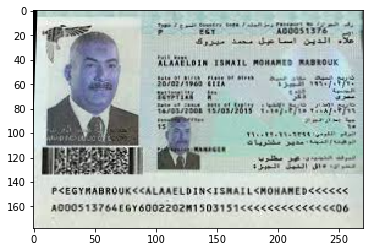

In [20]:
QueryImgBGR = cv2.imread("pass6.jpg")
#QueryImgBGR = final
QueryImg=cv2.cvtColor(QueryImgBGR,cv2.COLOR_BGR2GRAY)

queryKP,queryDesc = detector.detectAndCompute(QueryImg,None)
matches           = flann.knnMatch(queryDesc,trainDesc,k=2)
goodMatch         = []

for m,n in matches:
    if(m.distance<0.75*n.distance):
        goodMatch.append(m)

if(len(goodMatch)>MIN_MATCH_COUNT):
    tp=[]
    qp=[]
    for m in goodMatch:
        tp.append(trainKP[m.trainIdx].pt)
        qp.append(queryKP[m.queryIdx].pt)
    tp,qp=np.float32((tp,qp))
    H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
    h,w=trainImg.shape
    trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
    queryBorder=cv2.perspectiveTransform(trainBorder,H)
    x_points=[]
    y_points=[]
    for border in queryBorder[0]:
        x_points.append(border[0])
        y_points.append(border[1])

    x_start=int(min(x_points))
    y_start=int(min(y_points))
    x_end=int(max(x_points))
    y_end=int(max(y_points))
    warped=QueryImgBGR[y_start:y_end,x_start:x_end]

else:
    print ("Not Enough match found- %d/%d"%(len(goodMatch),MIN_MATCH_COUNT))
    
Edged = four_point_transform(QueryImgBGR, queryBorder.reshape(4, 2))
plt.imshow(Edged)

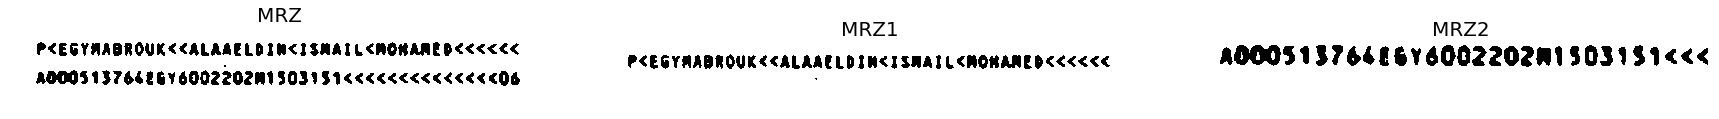

In [21]:
Kernel = np.ones((2,2), np.uint8)
Kernel_sharpen = np.array([[-1,-1,-1], [-1, 9,-1],[-1,-1,-1]])

Edged_Resized = cv2.resize(Edged,(1600,1100))

Edged_Gray = cv2.cvtColor(Edged_Resized, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
MRZ  = Edged_Gray[850:1050,80:1550]
MRZ = clahe.apply(MRZ)


MRZ1   = MRZ[0:120,0:1550]
MRZ2   = MRZ[120:250,0:1015]



_,MRZ1 = cv2.threshold(MRZ1,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
MRZ1   = cv2.dilate(MRZ1,Kernel,iterations=1)

_,MRZ2 = cv2.threshold(MRZ2,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
MRZ2   = cv2.dilate(MRZ2,Kernel,iterations=1)


_,MRZ = cv2.threshold(MRZ,220,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
MRZ   = cv2.dilate(MRZ,Kernel,iterations=1)


figures = {"MRZ":MRZ,"MRZ1":MRZ1,"MRZ2":MRZ2}
plot_figures(figures, nrows = 1, ncols=3,imSize=30,fSize=20)

In [22]:
config = '-l eng --oem 1 --psm 11'
Upper = pytesseract.image_to_string(MRZ1,config=config)
print(Upper)

PKEGYRABROUK<<ALAAELDIN<ISMAL L <MONMARED<<<<<<


In [24]:
config = '-l eng --oem 1 --psm 11'
Lower = pytesseract.image_to_string(MRZ2,config=config)
print(Lower)

A0005 13764667 6002202N1 50318 1<<<
